# TF Compare (Het vs iPSC reprogramming RNA-seq)

Compare RNA-seq data from the heterokaryon system (Thach's data, GSE103509) with RNA-seq from Cachiarelli et al to identify. In this notebook, look for TFs that are expressed in one dataset and not in another.

In [395]:
library(ggplot2)
library(matrixStats)
library(patchwork)
library(reshape2)
library(ggrepel)

In [3]:
# load bulk RNA-seq data
fpkm_ipsc = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm_ipsc$gene_id = NULL
fpkm_ipsc$locus=NULL
tpm_ipsc = fpkm_ipsc
tpm_ipsc[,2:ncol(tpm_ipsc)] = 1e6*t(t(tpm_ipsc[,2:ncol(tpm_ipsc)])/colSums(tpm_ipsc[,2:ncol(tpm_ipsc)]))

# removing genes with dup names
tpm_ipsc = tpm_ipsc[!duplicated(tpm_ipsc$gene_short_name),]
rownames(tpm_ipsc) = tpm_ipsc$gene_short_name
tpm_ipsc$gene_short_name = NULL

tpm_ipsc["GAPDH",]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,7803.64,4963.505,3908.693,3839.776,3795.548,3364.503,3032.412,3790.955,5598.224,4731.256


In [9]:
tpm_het = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE103509/tpm.matrix.txt", sep='\t', header=T)
tpm_het = tpm_het[tpm_het$Gene!="None", ]
tpm_het = tpm_het[!duplicated(tpm_het$Gene),]
rownames(tpm_het) = tpm_het$Gene
tpm_het$Gene = NULL
tpm_het$Ensembl = NULL

tpm_het["GAPDH",]

,GSM2772599_hFb_MRC5_rep1,GSM2772600_hFb_MRC5_rep2,GSM2772601_hFb_MRC5_rep3,GSM2772602_Co.cult_rep1,GSM2772603_Co.cult_rep2,GSM2772604_co.cult_rep3,GSM2772605_30min_rep1,GSM2772606_30min_rep2,GSM2772607_30min_rep3,GSM2772608_2h_rep1,⋯,GSM2772610_2h_rep3,GSM2772611_6h_rep1,GSM2772612_6h_rep2,GSM2772613_6h_rep3,GSM2772614_12h_rep1,GSM2772615_12h_rep2,GSM2772616_12h_rep3,GSM2772617_24h_rep1,GSM2772618_24h_rep2,GSM2772619_24h_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,4909.54,4797.98,3419.12,5400.76,5767.35,4277.84,5474.26,5490.53,4537.26,4826.46,⋯,4173.66,5217.96,5214.19,4473.25,5868.08,5776.31,4581.95,6361.69,5933.19,5486.53


In [197]:
# shorten names
colnames(tpm_het) = paste(paste(lapply(strsplit(colnames(tpm_het), "_"), "[[", 2), 
                                lapply(strsplit(colnames(tpm_het), "_"), "tail", 1),
                          sep='_'))

In [15]:
common_genes = intersect(rownames(tpm_het), rownames(tpm_ipsc))

In [163]:
# correlation between start states
cor(tpm_het[common_genes, 1], tpm_ipsc[common_genes, 1])

[1] 0.7827769

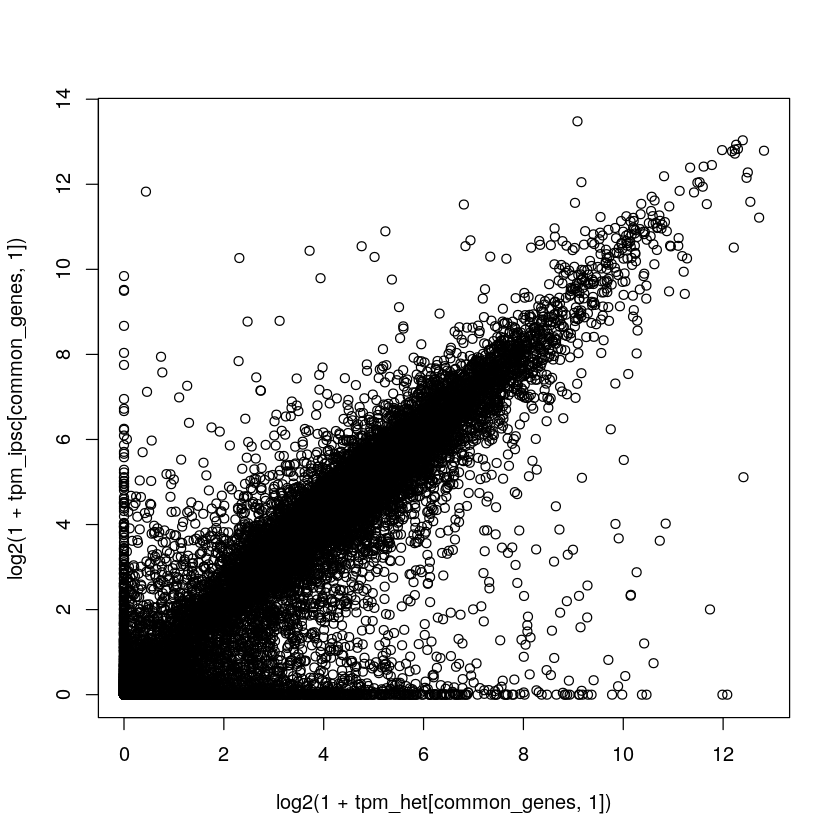

In [167]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot(log2(1+tpm_het[common_genes, 1]), log2(1+tpm_ipsc[common_genes, 1]))

In [35]:
# correlation between start vs end states
cor(tpm_het[common_genes, 1], tpm_ipsc[common_genes, 10])
cor(tpm_het[common_genes, 21], tpm_ipsc[common_genes, 1])

[1] 0.6170815

[1] 0.6960033

In [32]:
# correlation between reps
cor(tpm_het[common_genes, 2], tpm_het[common_genes, 1])

[1] 0.9943741

In [73]:
gen_plot <- function(gene_mat, gene_name, ylabel) {
    p <- ggplot(melt(gene_mat)) +
    geom_line(aes(x=variable, y=value, col=gene_name, group=gene_name),size=1.5) +
    geom_point(aes(x=variable, y=value, col=gene_name, group=gene_name),size=3) +
    ylab(ylabel) + xlab("Sample") +
    theme_bw(base_size=14) +
    ggtitle(gene_name) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
    #      plot.background = element_blank(),
    plot.title = element_text(hjust = 0.5),
    panel.border = element_blank(),
    panel.grid.minor = element_blank())
    
    p
}

## TF Analysis

In [38]:
tf_list = read.table("/users/surag/kundajelab/scATAC-reprog/resources/FANTOM5/tf.txt")
tf_list = as.character(unlist(tf_list$V1))

In [41]:
length(tf_list)
head(tf_list)

[1] 1672

[1] "AHR"   "AR"    "ARNT"  "CEBPA" "CREB1" "CTCF"

In [44]:
common_tfs = intersect(tf_list,common_genes)
length(common_tfs)

[1] 1620

In [449]:
# filter by criteria
gene_set = common_tfs

# low in hets, fibroblasts. Intermediate max in iPSC reprog
criteria = (rowMaxs(as.matrix(tpm_het[gene_set, ]))<= 2) &
           (tpm_ipsc[gene_set, 1] <= 2) &
           (tpm_ipsc[gene_set, 10] <= 10) &
           (rowMaxs(as.matrix(tpm_ipsc[gene_set, ])) > 5) &
           (rowMaxs(as.matrix(tpm_ipsc[gene_set, ])) == rowMaxs(as.matrix(tpm_ipsc[gene_set, 2:4])))

# different initial expression
# criteria = (rowMaxs(as.matrix(tpm_het[gene_set, 1:3]))>= 10) &
#             (tpm_ipsc[gene_set, 1] < 2)


sum(criteria)

[1] 22

In [450]:
gene_set[criteria]

[1] "FOXF2"   "BMP2"    "HOPX"    "HOXB3"   "HOXB5"   "HOXB6"   "HOXB7"  
 [8] "MEIS3"   "MEIS3P1" "MSC"     "MSX2"    "PRRX2"   "SALL1"   "TBX5"   
[15] "TCF21"   "TOX2"    "ZBED1"   "ZBTB1"   "ZNF135"  "ZNF22"   "ZNF32"  
[22] "ZNF573"

In [367]:
# for (x in gene_set[criteria]) {
#     cat(sprintf("%s\n", x))
# }

## Gene Plots

In [602]:
GENE = "^SMAD1$" # regex

In [603]:
gene_tpm_het = tpm_het[grep(GENE, rownames(tpm_het)),]
gene_tpm_het$gene_name = rownames(gene_tpm_het)
gene_tpm_ipsc = tpm_ipsc[grep(GENE, rownames(tpm_ipsc)),]
gene_tpm_ipsc$gene_name = rownames(gene_tpm_ipsc)

In [604]:
plot_tpm_het = gen_plot(gene_tpm_het, GENE, "TPM")
plot_tpm_ipsc = gen_plot(gene_tpm_ipsc, GENE, "TPM")

Using gene_name as id variables

Using gene_name as id variables



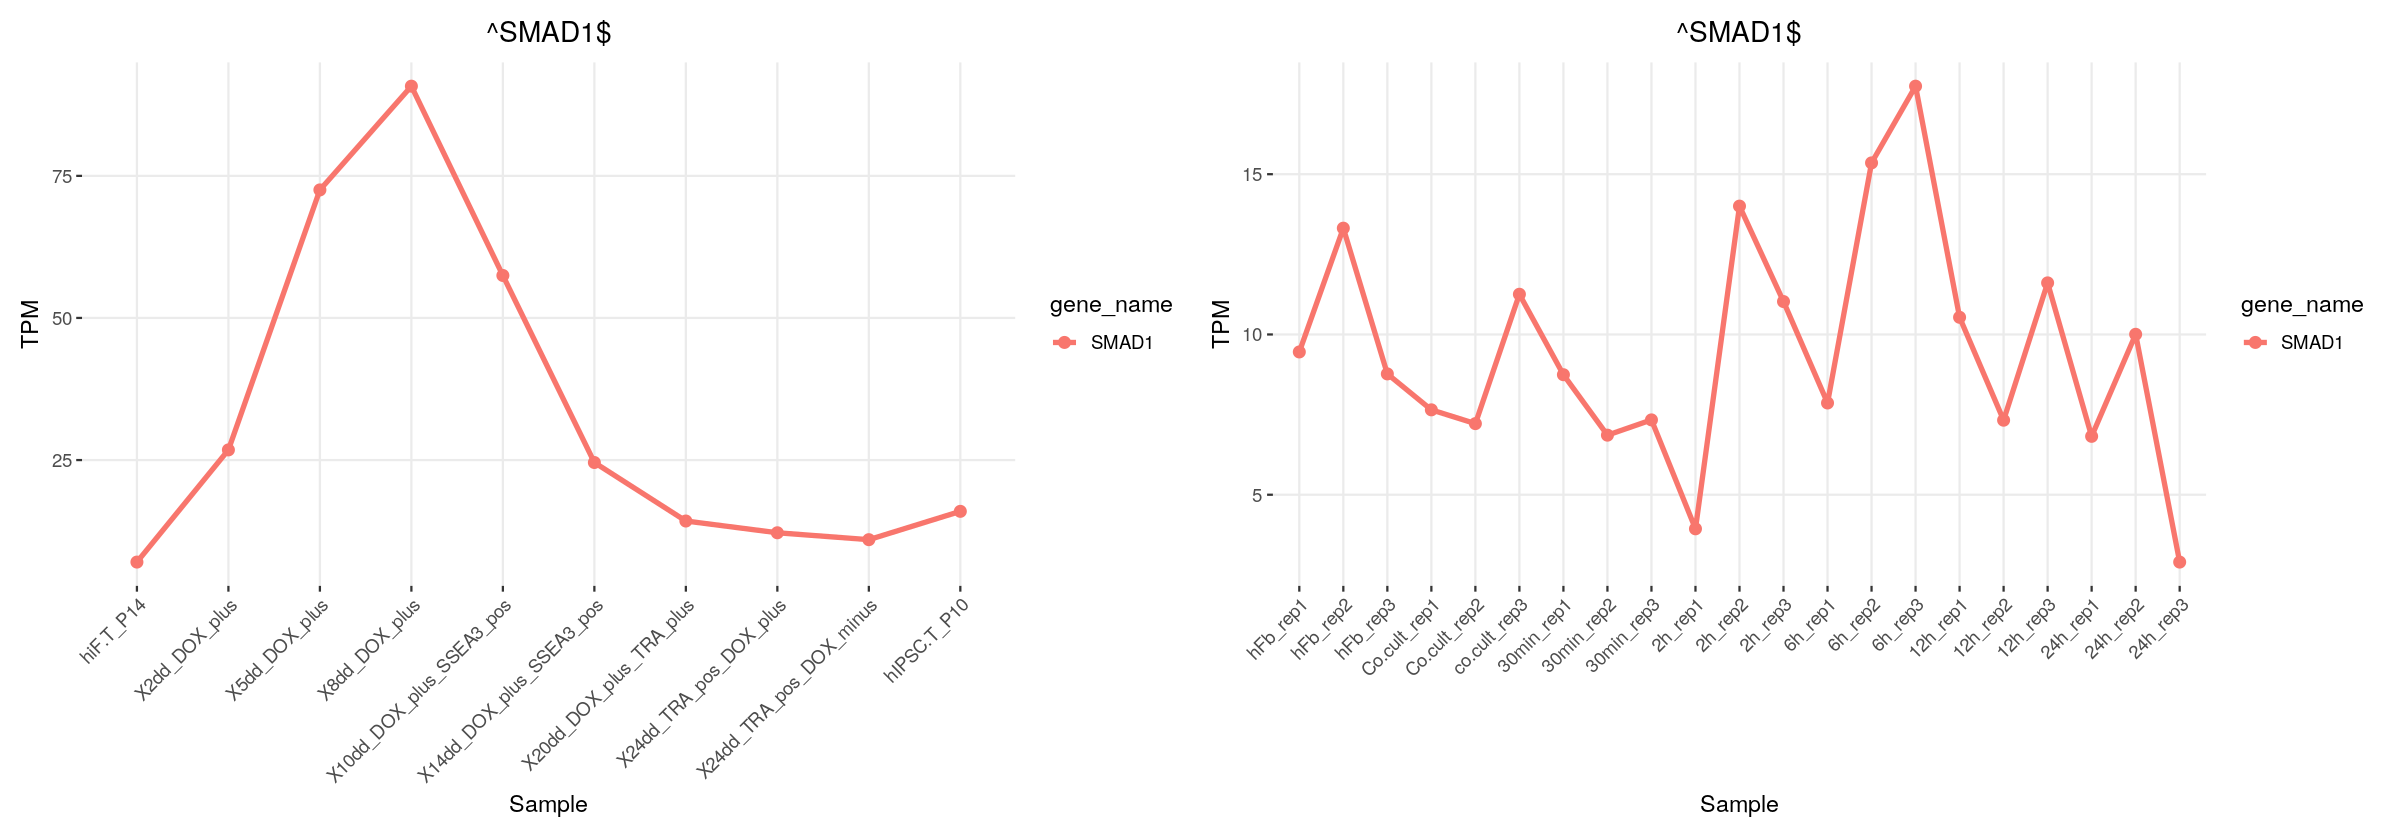

In [605]:
options(repr.plot.width = 20, repr.plot.height = 7)
plot_tpm_ipsc | plot_tpm_het

In [460]:
gene_tpm_ipsc

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NANOG,0.08211341,0.2828901,0.7413101,26.29678,45.6319,145.9749,201.0637,191.9591,187.8735,59.66981,NANOG


In [436]:
gene_tpm_het

,hFb_rep1,hFb_rep2,hFb_rep3,Co.cult_rep1,Co.cult_rep2,co.cult_rep3,30min_rep1,30min_rep2,30min_rep3,2h_rep1,⋯,6h_rep1,6h_rep2,6h_rep3,12h_rep1,12h_rep2,12h_rep3,24h_rep1,24h_rep2,24h_rep3,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
JUND,97.1937,77.0562,82.3355,77.4320,76.9837,68.1661,339.591,352.910,197.915,391.508,⋯,106.0730,106.587,55.9438,201.5650,200.6830,72.0878,236.6970,250.1580,179.9390,JUND
JUN,89.2757,85.9434,61.4583,42.5178,43.8244,39.4545,459.624,456.583,353.001,203.265,⋯,98.4659,106.063,79.2162,50.6077,43.9523,46.8536,35.2613,29.6774,27.6466,JUN
JUNB,44.3834,44.2029,35.1898,45.1724,47.5036,88.5647,484.519,488.959,438.086,221.611,⋯,47.5725,54.713,68.1252,37.3631,48.8627,48.1396,34.1099,32.1012,54.3154,JUNB


## PCA

In [389]:
tpm_combined = cbind(tpm_het[common_genes,], tpm_ipsc[common_genes,])
dim(tpm_combined)

[1] 26732    31

In [390]:
log_tpm_combined = log2(1+tpm_combined)

In [401]:
pca = prcomp(t(log_tpm_combined),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)

pcs$sample = c(lapply(strsplit(pcs$ID[1:21], '_'), "[[",1), # het reps
               pcs$ID[22:31]) # iPSC

var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

 [1] 57.70  9.38  5.88  3.50  3.18  2.67  2.04  1.89  1.54  1.10  1.07  0.99
[13]  0.93  0.90  0.78  0.69  0.68  0.67  0.62  0.58  0.53  0.50  0.48  0.45
[25]  0.35  0.29  0.21  0.17  0.14  0.09  0.00


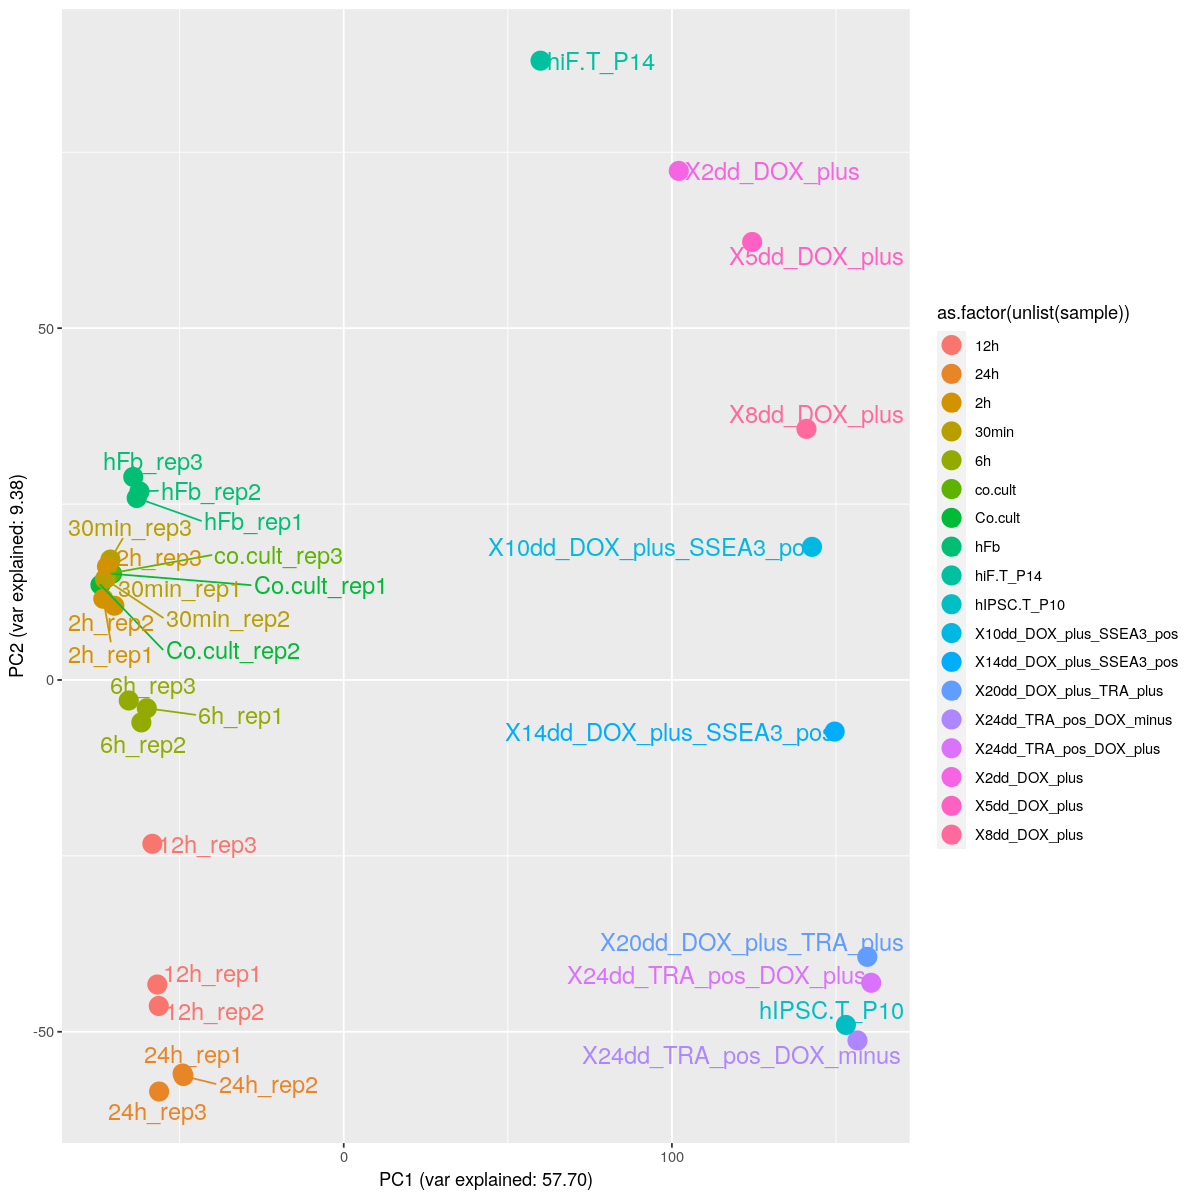

In [411]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(unlist(sample)),label=ID))+
geom_point(size=5)+
# scale_colour_manual(values = col_vector[seq(50,67)]) +
geom_text_repel(size=5, nudge_x=10)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))